In [2]:
import cv2
import numpy as np

def getContours(img,cThr=[100,100],showCanny=False,minArea=1000,filter=0,draw =False):
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray,(5,5),1)
    imgCanny = cv2.Canny(imgBlur,cThr[0],cThr[1])
    kernel = np.ones((5,5))
    imgDial = cv2.dilate(imgCanny,kernel,iterations=3)
    imgThre = cv2.erode(imgDial,kernel,iterations=2)
    if showCanny:cv2.imshow('Canny',imgThre)
    contours,hiearchy = cv2.findContours(imgThre,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    finalCountours = []
    for i in contours:
        area = cv2.contourArea(i)
        if area > minArea:
            peri = cv2.arcLength(i,True)
            approx = cv2.approxPolyDP(i,0.02*peri,True)
            bbox = cv2.boundingRect(approx)
            if filter > 0:
                if len(approx) == filter:
                    finalCountours.append([len(approx),area,approx,bbox,i])
            else:
                finalCountours.append([len(approx),area,approx,bbox,i])
    finalCountours = sorted(finalCountours,key = lambda x:x[1] ,reverse= True)
    if draw:
        for con in finalCountours:
            cv2.drawContours(img,con[4],-1,(0,0,255),3)
    return img, finalCountours

def reorder(myPoints):
    #print(myPoints.shape)
    myPointsNew = np.zeros_like(myPoints)
    myPoints = myPoints.reshape((4,2))
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints,axis=1)
    myPointsNew[1]= myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

def warpImg (img,points,w,h,pad=20):
    # print(points)
    points =reorder(points)
    pts1 = np.float32(points)
    pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imgWarp = cv2.warpPerspective(img,matrix,(w,h))
    imgWarp = imgWarp[pad:imgWarp.shape[0]-pad,pad:imgWarp.shape[1]-pad]
    return imgWarp

def findDis(pts1,pts2):
    return ((pts2[0]-pts1[0])**2 + (pts2[1]-pts1[1])**2)**0.5


In [3]:
import cv2

###################################
webcam = False  # Dont use Web Camera
path = '1.jpg'
cap = cv2.VideoCapture(0)
cap.set(10,160)
cap.set(3,1920)
cap.set(4,1080)
scale = 3
wP = 210 *scale
hP= 297 *scale
###################################

while True:
    if webcam:success,img = cap.read()
    else: img = cv2.imread(path)

    imgContours , conts = getContours(img,minArea=50000,filter=4)
    if len(conts) != 0:
        biggest = conts[0][2]
        #print(biggest)
        imgWarp = warpImg(img, biggest, wP,hP)
        imgContours2, conts2 = getContours(imgWarp,
                                                 minArea=2000, filter=4,
                                                 cThr=[50,50],draw = False)
        if len(conts) != 0:
            for obj in conts2:
                cv2.polylines(imgContours2,[obj[2]],True,(0,255,0),2)
                nPoints = reorder(obj[2])
                nW = round((findDis(nPoints[0][0]//scale,nPoints[1][0]//scale)/10),1)
                nH = round((findDis(nPoints[0][0]//scale,nPoints[2][0]//scale)/10),1)
                cv2.arrowedLine(imgContours2, (nPoints[0][0][0], nPoints[0][0][1]), (nPoints[1][0][0], nPoints[1][0][1]),
                                (255, 0, 255), 3, 8, 0, 0.05)
                cv2.arrowedLine(imgContours2, (nPoints[0][0][0], nPoints[0][0][1]), (nPoints[2][0][0], nPoints[2][0][1]),
                                (255, 0, 255), 3, 8, 0, 0.05)
                x, y, w, h = obj[3]
                cv2.putText(imgContours2, '{}cm'.format(nW), (x + 30, y - 10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5,
                            (255, 0, 255), 2)
                cv2.putText(imgContours2, '{}cm'.format(nH), (x - 70, y + h // 2), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5,
                            (255, 0, 255), 2)
        cv2.imshow('A4', imgContours2)

    img = cv2.resize(img,(0,0),None,0.5,0.5)
    cv2.imshow('Original',img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

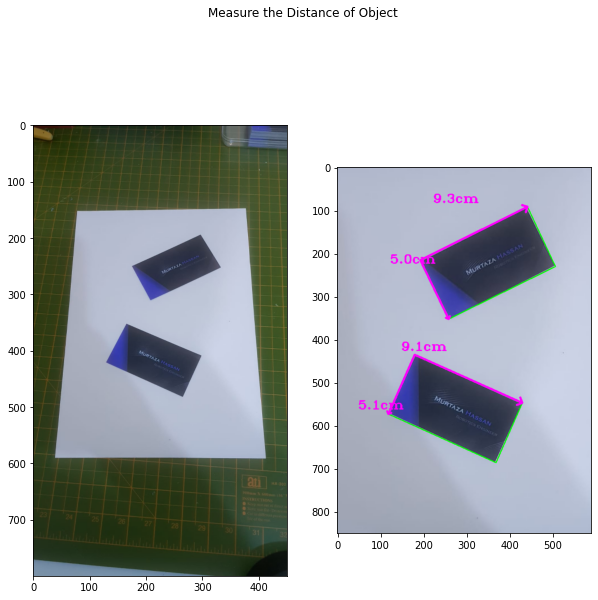

In [30]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
fig.suptitle('Measure the Distance of Object')
ax1.imshow(img)
ax2.imshow(imgContours2)
